In [26]:
import numpy as np
import tensorflow as tf
from tensorflow.python.ops import math_ops
from ESN import EchoStateRNNCell
import matplotlib.pyplot as plt

# takes only current needed GPU memory
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

# random numbers
random_seed = 1
rng = np.random.RandomState(random_seed)

We define a simple simulation with a single batch. A timeseries of 'stime' timesteps is run. The input is a inpulse 
given in the first timestep consisting of a gaussian noise given to each unit.

In [27]:
# Global variables
batches = 1
stime = 200
num_units = 100
init_state = np.zeros([batches, num_units], dtype="float32")
rnn_inputs = np.zeros((batches, stime, num_units), dtype="float32")
rnn_inputs[0, 0, :] = np.random.randn(num_units)*100

activation = lambda x: math_ops.maximum(0.0, math_ops.tanh(x))


Implementing a static graph without tensorflow API:

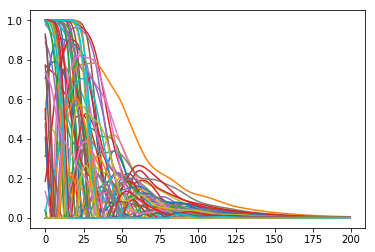

In [29]:

with tf.Graph().as_default() as g:
        
    rng = np.random.RandomState(random_seed)

    # Init the ESN cell
    cell = EchoStateRNNCell(num_units=num_units, 
                            activation=activation, 
                            decay=0.100, 
                            epsilon=1e-10,
                            alpha=0.300,
                            rng=rng)
    
    # Build the graph
    states = []
    prev_state = init_state
    for t in range(200):
        out,prev_state = cell(inputs=rnn_inputs[0,t,:], state=prev_state)
        states.append(out)

    # Run the simulation
    with tf.Session(config=config) as sess:
        tf.get_variable_scope().reuse_variables()
        sess.run(tf.global_variables_initializer())
        curr_states = np.vstack(sess.run(states))
        plt.plot(np.squeeze(curr_states))
        plt.show()

Implementing a dynamic graph using tensorflow API

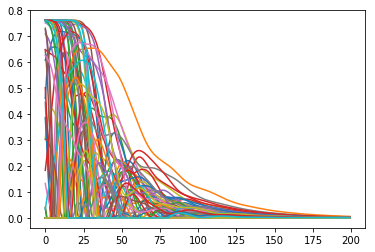

In [28]:
with tf.Graph().as_default() as g:
    
    rng = np.random.RandomState(random_seed)
    
    # Init the ESN cell
    cell = EchoStateRNNCell(num_units=num_units, 
                            activation=activation, 
                            decay=0.100, 
                            epsilon=1e-10,
                            alpha=0.300,
                            rng=rng)
    
    # Build the graph using the API
    states, final_state = tf.nn.dynamic_rnn(cell, 
                                            rnn_inputs, 
                                            initial_state=init_state)
    outs = activation(states)   
    
    # Run the simulation
    with tf.Session(config=config) as sess:
        tf.get_variable_scope().reuse_variables()
        sess.run(tf.global_variables_initializer())
        outs = np.vstack(sess.run(outs))
        plt.plot(np.squeeze(outs))
        plt.show()
    